In [19]:
#Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [20]:
#GPU Checking
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU is not available. Using CPU.")

Using GPU: NVIDIA GeForce RTX 3060


In [21]:
#Grabbing Datasets
hd_train = pd.read_csv('./datasets/house-train.csv')

#Grab Feature Columns
feature_cols = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF',
            'FullBath', 'YearBuilt', 'YearRemodAdd', 'Fireplaces',
            'LotFrontage','WoodDeckSF','OpenPorchSF',
            'ExterQual','Neighborhood','MSZoning',
            'Alley','LotShape','LandContour','Condition1','HouseStyle',
            'MasVnrType','SaleCondition',]

encode_cols = ['Neighborhood','MSZoning','Alley','LotShape','LandContour','Condition1','HouseStyle','MasVnrType','SaleCondition']

hd = pd.get_dummies(hd_train, columns= encode_cols)
hd = hd_train.replace({True: 1, False: 0})

features = hd[encode_cols].copy()
target = hd_train['SalePrice'].values.reshape(-1,1)

#Convert to floats and handle NaN values + scaling
features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
features = StandardScaler().fit_transform(features)

In [22]:
#Train-Test Split
x_train, x_val, y_train, y_val = train_test_split(features, target, test_size= 0.2, random_state= 0)

#training tensors
x_trainT = torch.tensor(x_train, dtype=torch.float32)
y_trainT = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

#Validation Tensors
x_valT = torch.tensor(x_val, dtype=torch.float32)
y_valT = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

In [23]:
#Data Loaders
train_dataset = TensorDataset(x_trainT, y_trainT)
valid_dataset = TensorDataset(x_valT, y_valT)

training_loader = DataLoader(dataset= train_dataset, batch_size= 16, shuffle= True)
valid_loader = DataLoader(dataset= valid_dataset, batch_size= 16, shuffle= False)


In [24]:
#Training Loop + Empty Arrays for storing Training and Validation Results
train_loss_list = []
val_loss_list = []

val_accuracy_list = []
all_predicted = []
all_labels = []

#Regression TL
def TL(n_epochs, optimizer, model, loss_fn, training_loader, valid_loader):
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    model.train()
    for inputs, targets in training_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      loss.backward()
      optimizer.step()
      loss_train += loss.item() * inputs.size(0)

    loss_train /= len(training_loader.dataset)
    train_loss_list.append(loss_train) 

    
    #Validation Loop
    model.eval()
    total = 0.0
    valid_loss = 0.0
    
    with torch.no_grad():
      for inputs, labels in valid_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          valid_loss += loss.item() * inputs.size(0)
          total += ((outputs - labels) ** 2).sum().item()
          

          
    valid_loss /= len(valid_loader.dataset)
    val_loss_list.append(valid_loss)
    rmse = np.sqrt(total / len(valid_loader.dataset))

    if epoch == 1 or epoch % 5 == 0: 
      print('Epoch: {}, Training Loss: {}, Validation Loss: {}, RMSE: {}'.format(epoch, loss_train / len(training_loader), valid_loss / len(valid_loader), rmse))
  

x_trainT.shape[1]

9

Problem 2B - One-Hot encoding

In [25]:
#Model
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(9, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512,256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 1)



    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = self.fc7(x)
        return x


In [26]:
#Training
model = RegressionNet().to(device)
a = 0.001
epochs = 100
lossFN = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= a)

TL(
  n_epochs= epochs,
  optimizer= optimizer,
  model= model,
  loss_fn= lossFN,
  training_loader= training_loader,
  valid_loader= valid_loader,
)

Epoch: 1, Training Loss: 525139256.2537061, Validation Loss: 1867566285.9812546, RMSE: 188371.33389569612
Epoch: 5, Training Loss: 85011070.6549071, Validation Loss: 367185060.63734674, RMSE: 83525.54191449218
Epoch: 10, Training Loss: 86206182.02289361, Validation Loss: 364926988.1816871, RMSE: 83268.31795738434
Epoch: 15, Training Loss: 84836113.55826609, Validation Loss: 363984316.0778659, RMSE: 83160.69988569993
Epoch: 20, Training Loss: 85465964.83242634, Validation Loss: 364587139.0454218, RMSE: 83229.53587436982
Epoch: 25, Training Loss: 85523774.78701445, Validation Loss: 365135719.5443403, RMSE: 83292.12850769552
Epoch: 30, Training Loss: 85319008.60649277, Validation Loss: 367167133.99279016, RMSE: 83523.50295493487
Epoch: 35, Training Loss: 85178347.00694314, Validation Loss: 366661489.5111752, RMSE: 83465.9709145729
Epoch: 40, Training Loss: 86224998.6834303, Validation Loss: 364352264.3056957, RMSE: 83202.72244228682
Epoch: 45, Training Loss: 84486189.9012948, Validation L

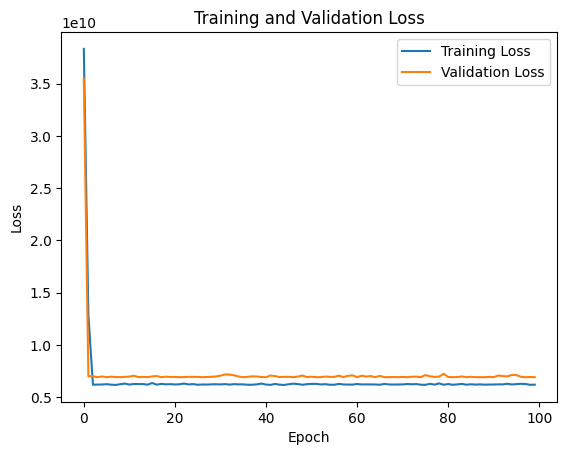

In [27]:
# Plotting training and validation loss
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#Overfitting is about the same as 2B but the model converges much faster